In [1]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from matplotlib import dates as mdates
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Load your stock prices data
df = pd.read_csv('/content/SCB.csv')
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Convert the data into a graph structure
timestamps = df.index.tolist()
prices = df['Price'].tolist()

<ipython-input-2-c9d929ff63a0>:13: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime


In [3]:
prices

[10900,
 10600,
 10900,
 11600,
 11100,
 11200,
 11300,
 11300,
 11200,
 11100,
 11100,
 11200,
 11200,
 11000,
 10900,
 10600,
 11000,
 11000,
 10800,
 10900,
 11200,
 11100,
 11200,
 11000,
 10900,
 11100,
 11000,
 11000,
 11000,
 10900,
 10900,
 10900,
 11000,
 11000,
 10800,
 10700,
 10800,
 10400,
 10600,
 10600,
 10600,
 10300,
 10400,
 10300,
 10100,
 10300,
 10300,
 10300,
 10300,
 10200,
 10300,
 10100,
 10100,
 10100,
 10100,
 10200,
 10200,
 10100,
 10000,
 10000,
 10200,
 10200,
 10300,
 10200,
 10200,
 10300,
 10300,
 10200,
 10300,
 10300,
 10300,
 10400,
 10300,
 11000,
 11700,
 12100,
 12700,
 12600,
 12400,
 11900,
 11700,
 11500,
 11200,
 11000,
 11300,
 11100,
 11000,
 11100,
 11200,
 11300,
 12000,
 11900,
 12100,
 12100,
 11500,
 11800,
 11800,
 11700,
 11600,
 11300,
 11300,
 11500,
 11500,
 11500,
 11300,
 11300,
 11300,
 11400,
 11300,
 11300,
 11300,
 11400,
 11300,
 11200,
 11200,
 11200,
 11200,
 11500,
 11500,
 11900,
 12100,
 11600,
 11200,
 11300,
 11100,


In [4]:
timestamps

[Timestamp('2016-01-20 00:00:00'),
 Timestamp('2016-01-21 00:00:00'),
 Timestamp('2016-01-22 00:00:00'),
 Timestamp('2016-01-25 00:00:00'),
 Timestamp('2016-01-26 00:00:00'),
 Timestamp('2016-01-27 00:00:00'),
 Timestamp('2016-01-28 00:00:00'),
 Timestamp('2016-01-29 00:00:00'),
 Timestamp('2016-01-02 00:00:00'),
 Timestamp('2016-02-02 00:00:00'),
 Timestamp('2016-03-02 00:00:00'),
 Timestamp('2016-04-02 00:00:00'),
 Timestamp('2016-05-02 00:00:00'),
 Timestamp('2016-02-15 00:00:00'),
 Timestamp('2016-02-16 00:00:00'),
 Timestamp('2016-02-17 00:00:00'),
 Timestamp('2016-02-18 00:00:00'),
 Timestamp('2016-02-19 00:00:00'),
 Timestamp('2016-02-22 00:00:00'),
 Timestamp('2016-02-23 00:00:00'),
 Timestamp('2016-02-24 00:00:00'),
 Timestamp('2016-02-25 00:00:00'),
 Timestamp('2016-02-26 00:00:00'),
 Timestamp('2016-02-29 00:00:00'),
 Timestamp('2016-01-03 00:00:00'),
 Timestamp('2016-02-03 00:00:00'),
 Timestamp('2016-03-03 00:00:00'),
 Timestamp('2016-04-03 00:00:00'),
 Timestamp('2016-07-

In [5]:
# Create edges where each timestamp is connected to the next one
edge_index = torch.tensor([list(range(len(timestamps)-1)), list(range(1, len(timestamps)))], dtype=torch.long)

# Create node features (price at each timestamp)
x = torch.tensor(prices[:-1], dtype=torch.float).view(-1, 1)  # Remove the last element to align with y

# Create a target variable (predict the next day's price)
y = torch.tensor(prices[1:], dtype=torch.float)

# Split the data into training and testing sets (90-10 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)
train_edge_index, test_edge_index = train_test_split(edge_index.t().numpy(), test_size=0.1,shuffle=False, random_state=42)


# Converting back to PyTorch tensors
train_edge_index = torch.tensor(train_edge_index, dtype=torch.long).t()
test_edge_index = torch.tensor(test_edge_index, dtype=torch.long).t()
train_edge_index = train_edge_index[:, :-1]
test_edge_index = test_edge_index[:, :-1]
# Find the minimum index in the edge_index tensor
min_index = test_edge_index.min()

# Shift the indices to start from 0
test_edge_index -= min_index
# Create PyTorch Geometric Data objects for training and testing
train_data = Data(x=x_train, edge_index=train_edge_index, y=y_train)
test_data = Data(x=x_test, edge_index=test_edge_index, y=y_test)


In [6]:
test_data

Data(x=[175, 1], edge_index=[2, 174], y=[175])

In [7]:
dim_h= 64
lr = 0.01
weight_decay = 5e-4
dropout = 0.1


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,SAGEConv,GATConv
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.datasets import CoraFull
torch.manual_seed(42)
# Define a simple GNN model
class SimpleGNN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = nn.Linear(num_features, hidden_size)
        self.conv2 = nn.Linear(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        return x
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    def forward(self, data):
        h = self.gcn1(data.x, data.edge_index)
        h = torch.relu(h)
        out = self.gcn2(h, data.edge_index)
        return out
class SAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    def forward(self, data):
        h = self.sage1(data.x, data.edge_index)
        h = torch.relu(h)
        h = self.sage2(h,data.edge_index)
        return h
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, num_heads):
        super(GAT, self).__init__()
        self.gat1 = GATConv(dim_in, dim_h, heads=num_heads)
        self.gat2 = GATConv(dim_h * num_heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    def forward(self,data):
        h = self.gat1(data,x, data.edge_index)
        h = torch.relu(h)
        out = self.gat2(h, data.edge_index)
        return out
# Instantiate the GNN model, loss function, and optimizer
model = SAGE(1,16,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the GNN on the training data
num_epochs = 300
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, train_data.y.view(-1, 1))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/300, Loss: 419861888.0
Epoch 2/300, Loss: 367027488.0
Epoch 3/300, Loss: 318285472.0
Epoch 4/300, Loss: 273676128.0
Epoch 5/300, Loss: 233104224.0
Epoch 6/300, Loss: 196375440.0
Epoch 7/300, Loss: 163252176.0
Epoch 8/300, Loss: 133498016.0
Epoch 9/300, Loss: 106903256.0
Epoch 10/300, Loss: 83308960.0
Epoch 11/300, Loss: 62623300.0
Epoch 12/300, Loss: 44824896.0
Epoch 13/300, Loss: 29940166.0
Epoch 14/300, Loss: 18039220.0
Epoch 15/300, Loss: 9173639.0
Epoch 16/300, Loss: 3345966.25
Epoch 17/300, Loss: 535391.875
Epoch 18/300, Loss: 804320.8125
Epoch 19/300, Loss: 3426251.25
Epoch 20/300, Loss: 6941392.5
Epoch 21/300, Loss: 10405147.0
Epoch 22/300, Loss: 13264749.0
Epoch 23/300, Loss: 15350401.0
Epoch 24/300, Loss: 16370305.0
Epoch 25/300, Loss: 16148280.0
Epoch 26/300, Loss: 14825787.0
Epoch 27/300, Loss: 12702172.0
Epoch 28/300, Loss: 10147461.0
Epoch 29/300, Loss: 7517744.0
Epoch 30/300, Loss: 5104933.5
Epoch 31/300, Loss: 3112386.5
Epoch 32/300, Loss: 1649260.875
Epoch 33/30

In [9]:
# Evaluate the model on the testing data
model.eval()
with torch.no_grad():
    test_predictions = model(test_data)

# Convert torch tensors to numpy arrays for plotting
x_train_np = x_train.numpy().flatten()
y_train_np = y_train.numpy()

x_test_np = x_test.numpy().flatten()
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.numpy().flatten()


In [10]:
# Tính MAE cho testing
mae_test = mean_absolute_error(y_test_np, test_predictions_np)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test_np, test_predictions_np)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test_np, test_predictions_np, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test_np,test_predictions_np, squared=False)
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('----------------------')


---------TEST----------
MAPE: 3.274
MAE: 667.789
RMSE: 861.965
MSLE: 0.043
----------------------


In [11]:
test_data

Data(x=[175, 1], edge_index=[2, 174], y=[175])

In [12]:
test_preddict=test_data

In [13]:
test_preddict

Data(x=[175, 1], edge_index=[2, 174], y=[175])

In [14]:
# Use the trained GNN model to make predictions for the next 30 days
model.eval()
future_x=[]
t=173
with torch.no_grad():
    for i in range(30):
        future_prediction = model(test_preddict)
        future_x.append(future_prediction[-1])
        new_edge = torch.tensor([[t+1], [t+2]], dtype=torch.long)
        test_preddict.x= torch.cat([test_preddict.x, future_prediction[-1].reshape(1,-1)])
        prices.append(future_prediction[-1])
        test_preddict.edge_index = torch.cat([test_preddict.edge_index, new_edge], dim=1)
        t+=1


In [15]:
future_x

[tensor([26535.3887]),
 tensor([26731.2129]),
 tensor([26600.4453]),
 tensor([26694.7148]),
 tensor([26634.5742]),
 tensor([26680.3164]),
 tensor([26653.4570]),
 tensor([26676.3789]),
 tensor([26665.1680]),
 tensor([26677.3633]),
 tensor([26673.5078]),
 tensor([26680.6602]),
 tensor([26680.2637]),
 tensor([26685.0449]),
 tensor([26686.2734]),
 tensor([26689.9395]),
 tensor([26691.9375]),
 tensor([26695.0781]),
 tensor([26697.4355]),
 tensor([26700.3301]),
 tensor([26702.8555]),
 tensor([26705.6367]),
 tensor([26708.2422]),
 tensor([26710.9688]),
 tensor([26713.6094]),
 tensor([26716.3145]),
 tensor([26718.9727]),
 tensor([26721.6660]),
 tensor([26724.3340]),
 tensor([26727.0195])]

In [16]:
future_timestamps = pd.date_range(start=timestamps[-1], periods=30, freq='B')  # Assuming business days


In [17]:
future_timestamps_np = mdates.date2num(future_timestamps)
future_prices_np = torch.tensor(future_x, dtype=torch.float).numpy()

In [18]:
prices

[10900,
 10600,
 10900,
 11600,
 11100,
 11200,
 11300,
 11300,
 11200,
 11100,
 11100,
 11200,
 11200,
 11000,
 10900,
 10600,
 11000,
 11000,
 10800,
 10900,
 11200,
 11100,
 11200,
 11000,
 10900,
 11100,
 11000,
 11000,
 11000,
 10900,
 10900,
 10900,
 11000,
 11000,
 10800,
 10700,
 10800,
 10400,
 10600,
 10600,
 10600,
 10300,
 10400,
 10300,
 10100,
 10300,
 10300,
 10300,
 10300,
 10200,
 10300,
 10100,
 10100,
 10100,
 10100,
 10200,
 10200,
 10100,
 10000,
 10000,
 10200,
 10200,
 10300,
 10200,
 10200,
 10300,
 10300,
 10200,
 10300,
 10300,
 10300,
 10400,
 10300,
 11000,
 11700,
 12100,
 12700,
 12600,
 12400,
 11900,
 11700,
 11500,
 11200,
 11000,
 11300,
 11100,
 11000,
 11100,
 11200,
 11300,
 12000,
 11900,
 12100,
 12100,
 11500,
 11800,
 11800,
 11700,
 11600,
 11300,
 11300,
 11500,
 11500,
 11500,
 11300,
 11300,
 11300,
 11400,
 11300,
 11300,
 11300,
 11400,
 11300,
 11200,
 11200,
 11200,
 11200,
 11500,
 11500,
 11900,
 12100,
 11600,
 11200,
 11300,
 11100,


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


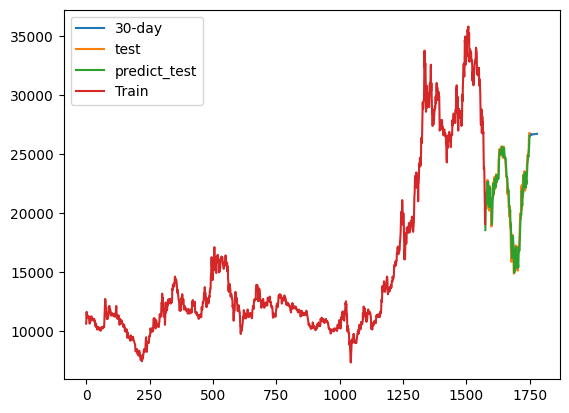

In [19]:
predict_data_index = pd.RangeIndex(start=1750, stop=1780, step=1)
plt.plot(predict_data_index, future_x, label='30-day')
test_data_index = pd.RangeIndex(start=1575, stop=1750, step=1)
plt.plot(test_data_index, y_test_np, label='test')
test_data_index = pd.RangeIndex(start=1575, stop=1750, step=1)
plt.plot(test_data_index, test_predictions_np, label='predict_test')
train_data_index = pd.RangeIndex(start=0, stop=1575, step=1)
plt.plot(train_data_index, y_train_np, label='Train')
plt.legend()
plt.show()